### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:0


In [4]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

In [5]:
def mk_model(model_name):
  
        
    if model_name == 'Unet':  # 완료
        from models.unet import UNet
        model = UNet(channel_in=3, channel_out=1)
        model = model.to(DEVICE) # load model to DEVICE
        
    
    if model_name == 'UNet++':  # 완료
        from models.nnUNet.nnunet import Nested_UNet as UNet_2p
        model = UNet_2p(1,3)
        model = model.to(DEVICE) # load model to DEVICE
      
    
    if model_name == 'ColonSegNet':  # 완료
        from models.ColonSegNet import CompNet as ColonSegNet
        model = ColonSegNet()
        model = model.to(DEVICE) # load model to DEVICE
      
        
    if model_name == 'DeepLab_V3+':  # 완료
        from models.DeepLab_V3_p.model import DeepLab as DeepLab_V3_p
        model = DeepLab_V3_p(backbone = 'resnet', num_classes = 1)   # backbone : 선택 (resnet, xception, mobilenet)
        model = model.to(DEVICE) # load model to DEVICE
    
        
    if model_name == 'SegNet':  # 완료
        from models.SegNet.models.segnet import SegResNet
        model = SegResNet(num_classes = 1)
        model = model.to(DEVICE) # load model to DEVICE
   
        
    if model_name == 'FCN':  # 완료
        from models.FCN.torchvision.models.segmentation.fcn import fcn_resnet101
        model = fcn_resnet101(num_classes = 1)
        model = model.to(DEVICE) # load model to DEVICE
        
    if model_name == 'FCBFormer':  # 완료
        from models.FCBformer.FCBmodels import FCBFormer
        
        model = FCBFormer(size=224)
        model = model.to(DEVICE)
    
    if model_name == 'ESFPNet':  # 완료
        from models.ESFPNet.ESFPmodel import ESFPNetStructure
        
        model = ESFPNetStructure(embedding_dim = 224)
        model = model.to(DEVICE)
    
    if model_name == 'ColonFormer':  # 완료 
        from mmseg.models.segmentors.colonformer import ColonFormer
        from mmseg.models.decode_heads.uper_head import UPerHead
        
        backbone=dict(type='mit_b3',style='pythorch')
        decode_head=dict(type='UPerHead', in_channels=[64], in_index=[0], channels=128, dropout_ratio=0.1,
                            num_classes=1, norm_cfg=dict(type='BN', requires_grad=True), align_corners=False,decoder_params=dict(embed_dim=768),
                            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0))
        model = ColonFormer(backbone,decode_head = decode_head,
                        neck=None,
                        auxiliary_head=None,
                        train_cfg=dict(),
                        test_cfg=dict(mode='whole'),
                        pretrained='mmseg/pretrained/mit_b3.pth')
        params = model.parameters()
        model = model.to(DEVICE)
  
    return model

    ###
    

# DICE

ISIC-2017
start:FCN
start:SegNet
start:DeepLab_V3+
start:Unet
start:UNet++
start:ColonSegNet
start:FCBFormer
start:ESFPNet
start:ColonFormer


2022-11-27 13:55:58,479 - mmseg - INFO - Use load_from_local loader
2022-11-27 13:55:58,554 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.weight, head.bias



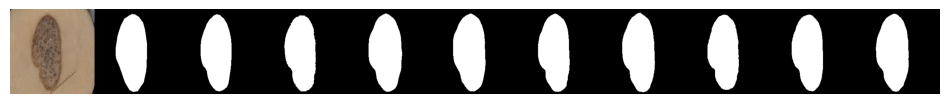

wound
start:FCN
start:SegNet


In [ ]:
models = ['FCN', 'SegNet', 'DeepLab_V3+', 'Unet', 'UNet++', 'ColonSegNet', 'FCBFormer','ESFPNet', 'ColonFormer']
BATCH_SIZE = 8
criterion = DiceBCELoss()

from ploting import plot_test_image

data_names = {'ISIC-2017':'ISIC', 'wound':'wound', 'Kvasir-SEG':'Kvasir', 'CVC-ClinicDB':'CVC',
             'breast_cancer_benign':'benign', 'breast_cancer_malignant':'malignant'}

for data_name in data_names:
    print(data_name)
    lst_model = []
    if 'breast_cancer' in data_name:
        name = data_name.split('breast_cancer_')[1]
        test_images = sorted(glob.glob(f'/data/segmentation/breast-cancer/testset_{name}/images/*'))
        test_labels = sorted(glob.glob(f'/data/segmentation/breast-cancer/testset_{name}/labels/*'))
        test_images = [img for img in test_images if img.find('jpg')!= -1] # super pixels 이미지 제외

    else:
        test_images = sorted(glob.glob(f'/data/segmentation/{data_name}/testset/images/*'))
        test_labels = sorted(glob.glob(f'/data/segmentation/{data_name}/testset/labels/*'))
        test_images = [img for img in test_images if img.find('jpg')!= -1] # super pixels 이미지 제외

    # 데이터셋 클래스 적용
#     custom_dataset_test = myDataSet(test_images, test_labels, transforms=test_transforms)
#     dataloader_test = torch.utils.data.DataLoader(custom_dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



    for model_name in models:
        print('start:' + model_name)
        model = mk_model(model_name)
        model.load_state_dict(torch.load(f'checkpoints/ckpt_{model_name}_{data_names[data_name]}.pth')['net'])
        
#         model.eval()
#         for i, (imgs, masks) in enumerate(dataloader_test):
#             imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

#             with torch.no_grad():
#                 ## Prediction
#                 prediction = model(imgs)
#             break  
        lst_model.append(model)
    plot_test_image(lst_model, DEVICE, test_images, test_labels, data_name)